# Data access template for H SAF NRT root-zone soil moisture product (H26)
## Introduction

The root-zone soil wetness index (SWI) products are available in Near Real-Time (NRT) or as Climate Data Record (CDR) daily products. The NRT products are produced within 12-36 hours of the analysis time. We recommend using the 10 km resolution NRT product RZSM-ASCAT-NRT-10km (H26) as the 25 km resolution version (SM-DAS-2) will be retired soon. The following table summarises the H26 product:   

<h2 style='padding: 10px'>H26 NRT product</h2><table class='table table-striped'> <thead> <tr> <th>Product name</th> <th>Type</th> <th>Period</th> <th>Obs assimilated</th> <th>DA system</th> <th>Resolution</th> <th>QC flags</th> </tr> </thead> <tbody> <tr> <th scope='row'>RZSM-ASCAT-NRT-10km (H26) </th> <td>NRT</td> <td>03/2022 onwards</td> <td> ASCAT-A/B/C SSM products (equivalent to H102/H103/H105) </td> <td> Regular updates of H SAF/ECMWF LDAS (47R2-) </td> <td> 10 km </td> <th> Yes (1=normal, 2=frozen risk, 3=outide nominal range) </tr> </tbody> </table>

H26 is provided in both grib (cubic octahedral reduced Gaussian grid) and netCDF4 (regular 0.1 degree lat/lon) formats. Using python software such as xarray, matplotlib and cartopy, it is straightforward to read in and plot the netCDF4 data directly. We will demonstrate some simple examples.

## Requirements:
- python version >3.6
- The following libraries: numpy, xarray, matplotlib, cartopy

## Objectives
In this exercise we will 

-  Download the netCDF files from H SAF ftp
-  Read the data in python
-  Plot the data in python
-  Plot a particular region
-  Plot a time series

## Data download
In order to access the H SAF ftp you will need to register:
https://hsaf.meteoam.it/User/Register. 
You will then be given a username and password for reading data from the H SAF ftp. For easy access and download from the ftp is it best to use software such as filezilla (https://filezilla-project.org/). Alternatively, to download example file RZSM-ASCAT-NRT-10km (H26) for 06/09/2021 from the terminal type:

ftp user@ftphsaf.meteoam.it

password: (type your password)

cd /products/h26/h26_cur_mon_nc

get h26_2024053000_R01.nc

exit

The below code segment sets up the necessary folders, defines date selection widgets for specifying the start and end dates, and provides widgets for user authentication, including username and password.

Ensure that the folder creation process and widget initialization are properly executed before proceeding with data download and processing. These steps are crucial for organizing data and ensuring user interaction for authentication and date selection.

In [1]:
%load_ext autoreload
%autoreload 2


import os
from datetime import datetime, date
import ipywidgets as widgets
from hsaf_data_access import HSAFDataAccess as data_access
from importlib import reload  # Python 3.4+

import xarray as xr
import matplotlib.pyplot as plt #For plotting figures
import cartopy.crs as ccrs
import numpy as np
import importlib


In [2]:
# Set up necessary folders
data_access.create_folders()

# Define working directory
work_dir = os.getcwd()
os.chdir(work_dir)
storedir = work_dir + '/data/'

# Date selection widgets
datestart = widgets.DatePicker(description='Start Date', disabled=False, value=date.today(), max=date.today())
dateend = widgets.DatePicker(description='End Date', disabled=False, value=date.today(), max=date.today())
display(widgets.HBox([datestart, dateend]))

# User authentication widgets
username = widgets.Text(description='Username:', disabled=False)
psw = widgets.Password(description='Password:', disabled=False)
display(widgets.HBox([username, psw]))

In [133]:
try:
    # Parameter data
    data_access.download_h26(username.value, psw.value, datestart.value, dateend.value, storedir, 'h26')
    
except Exception as e:
    print(f'Error downloading data: {str(e)}')


products/h26/h26_cur_mon_nc/
Info: Preparing data download...
Info: h26_2024040100_R01.nc downloaded
Info: h26_2024040200_R01.nc downloaded
Info: h26_2024040300_R01.nc downloaded
Info: h26_2024040400_R01.nc downloaded
Info: h26_2024040500_R01.nc downloaded
Info: h26_2024040600_R01.nc downloaded
Info: h26_2024040700_R01.nc downloaded
Info: h26_2024040800_R01.nc downloaded
Info: h26_2024040900_R01.nc downloaded
Info: h26_2024041000_R01.nc downloaded
Info: h26_2024041100_R01.nc downloaded
Info: h26_2024041200_R01.nc downloaded
Info: h26_2024041300_R01.nc downloaded
Info: h26_2024041400_R01.nc downloaded
Info: h26_2024041500_R01.nc downloaded
Info: h26_2024041600_R01.nc downloaded
Info: h26_2024041700_R01.nc downloaded
Info: h26_2024041800_R01.nc downloaded
Info: h26_2024041900_R01.nc downloaded
Info: h26_2024042000_R01.nc downloaded
Info: h26_2024042100_R01.nc downloaded
Info: h26_2024042200_R01.nc downloaded
Info: h26_2024042300_R01.nc downloaded
Info: h26_2024042400_R01.nc downloaded
In

## Data reading and pre-processing

In [134]:
SM=xr.open_mfdataset(storedir+"/*R01.nc")

In [135]:
# Take a time mean of the different layers (layer 1 (var40) = 0-0.07 m, layer 2 (var41) = 0.07-0.28 m, layer 3 (var42) = 0.28-1.00 m depth)

SM_layer1=SM.var40.mean(dim = "time")
SM_layer2=SM.var41.mean(dim = "time")
SM_layer3=SM.var42.mean(dim = "time")



In [36]:
#Take a time mean of SM layer 3, but masking frozen data

SM_layer3_qc=SM.var42.where(SM.var200<=1.0, np.nan).mean(dim="time", skipna=True)[:,:,0]

## Visualization 

### SM maps
The visualization example illustrates the spatial distribution of the April 2024 H26 SM over the study area for the selected period. Each point on the map represents the average layer 3 SWI over April 2024 in units between 0 (residual SM) and 1 (saturation_. The map provides insights into the spatial variability of SM across different regions, including very dry conditions over the deserts and wet conditions over midlatitudes. The quality control removes points where the soil temperature is less than 277 K, which indicates a risk of frozen conditions. 

In [139]:
# Generic function for plotting maps in cartopy with a regular lat/lon grid
def map_imshow(data, proj=ccrs.PlateCarree(), axes=None, region=None, **kwargs):
    if axes == None:
        fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(16,6)) 
    else:
        ax = axes
    ax.coastlines() # show coastlines

    cmap=plt.cm.get_cmap('coolwarm_r') #Choose colour map type 

    ax.gridlines()
    sc = ax.imshow(data,origin='upper',cmap=cmap,extent=[0.0,360.,-90,90],transform=ccrs.PlateCarree(), **kwargs)
    
    plt.colorbar(sc,ax=ax,orientation='horizontal',fraction=0.05); 
    gl = ax.gridlines(draw_labels=True, alpha=.3, color='grey', 
                      linewidth=0.5,linestyle ='-', 
                      x_inline= False, y_inline=False)
    gl.n_steps = 100
    gl.top_labels = False
    gl.right_labels = False

    if region=="euro": # specific domain for Europe
        ax.set_extent([-20, 30, 62, 35], crs=ccrs.PlateCarree())
    return None

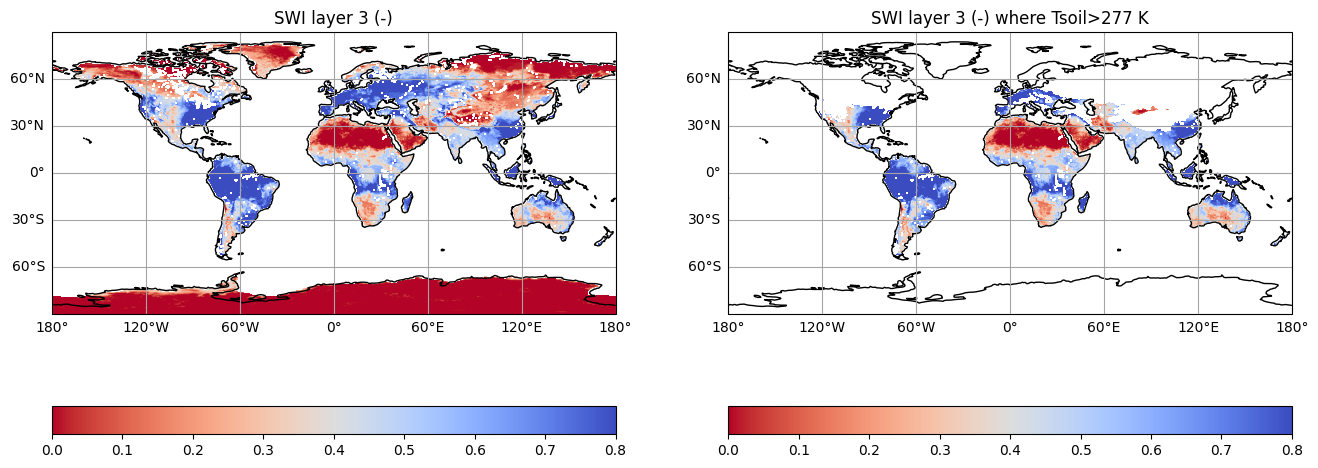

In [140]:
### Plot global maps and save
ax_titles=["SWI layer 3 (-)", "SWI layer 3 (-) where Tsoil>277 K"] 

fig, ax = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))
axes = ax.flatten()

# Layer 3 plot without quality control screening:
map_imshow(SM_layer3, axes=axes[0], vmin=0.0, vmax=0.8)
axes[0].set_title(ax_titles[0])

# Layer 3 plot with quality control screening:
map_imshow(SM_layer3_qc, axes=axes[1], vmin=0.0, vmax=0.8)
axes[1].set_title(ax_titles[1])

plt.show()
plt.savefig('H26_global_map_April_2024.png',dpi=300,bbox_inches='tight') #To save in png format
plt.close()


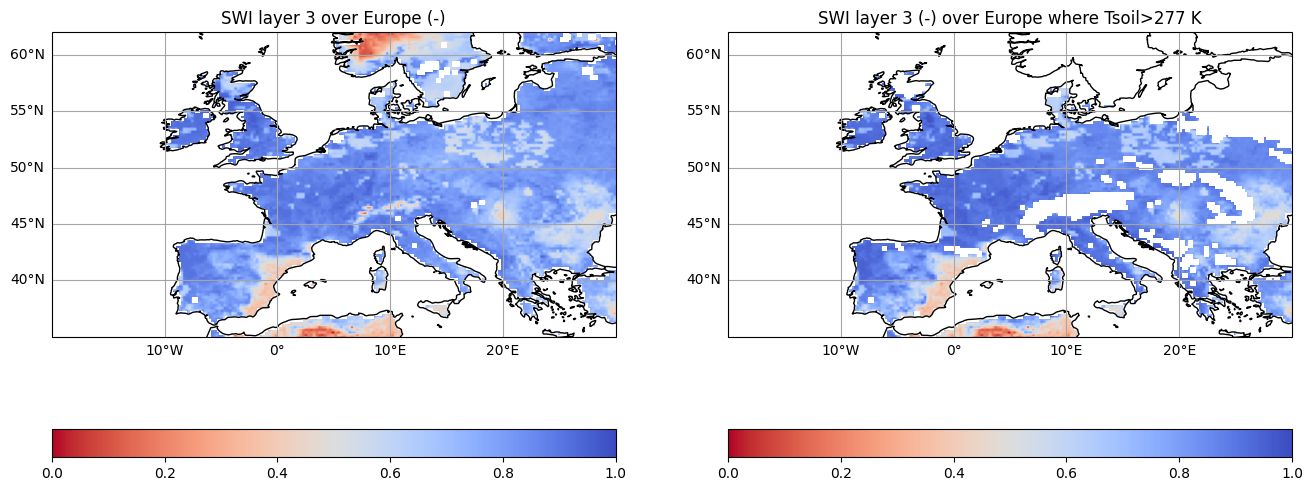

In [141]:
### Plot maps over Europe and save
ax_titles=["SWI layer 3 over Europe (-)", "SWI layer 3 (-) over Europe where Tsoil>277 K"] 

fig, ax = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))
axes = ax.flatten()

# Layer 3 plot without quality control screening:
map_imshow(SM_layer3, axes=axes[0], vmin=0.0, vmax=1.0, region="euro")
axes[0].set_title(ax_titles[0])

# Layer 3 plot with quality control screening:
map_imshow(SM_layer3_qc, axes=axes[1], vmin=0.0, vmax=1.0, region="euro")
axes[1].set_title(ax_titles[1])

plt.savefig('H26_Europe_map_April_2024.png',dpi=300,bbox_inches='tight') #To save in png format
plt.show()
plt.close()


### SM time series
The visualization example illustrates the SM time series over April 2024 for the nearest point to Vienna in Austria. The top layer is very sensitive to the short-term atmospheric forcing. Layers 2 and 3 have slower temporal scales with layer 3 more sensitive to seasonal variability.

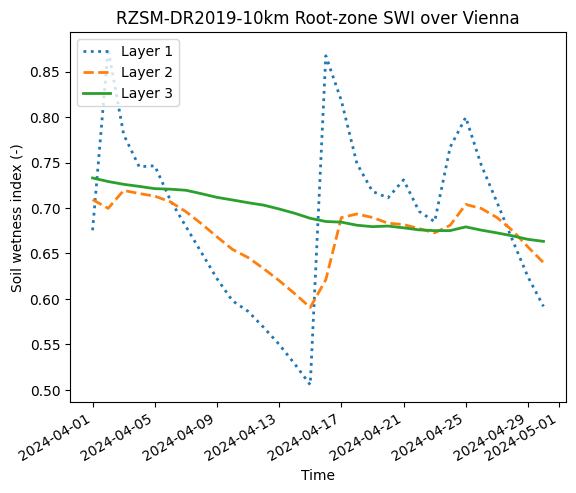

In [143]:
#Create the time series
#Read in H26 SWI for layers 1-3 over Vienna over the analysis period
lat,lon = "48.1","16.4"

Time_series_layer1=SM.var40.sel(lat=lat,lon=lon,method="nearest")
Time_series_layer2=SM.var41.sel(lat=lat,lon=lon,method="nearest")
Time_series_layer3=SM.var42.sel(lat=lat,lon=lon,method="nearest")

#Plot the time series 
Time_series_layer1.plot(label='Layer 1',linestyle=':',linewidth=2.0)  
Time_series_layer2.plot(label='Layer 2',linestyle='--',linewidth=2.0) 
Time_series_layer3.plot(label='Layer 3',linewidth=2.0) 

plt.legend(loc="upper left")

plt.xlabel('Time'); plt.ylabel('Soil wetness index (-)'); 
plt.title('RZSM-DR2019-10km Root-zone SWI over Vienna'); 
plt.show()
plt.close()